In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv
from sklearn.cluster import KMeans

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_cleaned
        """

In [7]:
ot = pd.read_sql(query, rs_connection)

In [8]:
print(f"There are {ot.duplicated().sum()} duplicated rows in the dataset")

There are 0 duplicated rows in the dataset


In [67]:
ot.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_year,invoice_month,invoice_weekday,invoice_dayname
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,1.25,24,30.00,2010-12-01 08:45:00,u12583,France,2010,12,2,Wednesday
1,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,19.95,1,19.95,2010-12-01 09:56:00,u1742,United Kingdom,2010,12,2,Wednesday
2,536392,22128,PARTY CONES CANDY ASSORTED,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom,2010,12,2,Wednesday
3,536404,22469,HEART OF WICKER SMALL,1.65,12,19.80,2010-12-01 11:29:00,u16218,United Kingdom,2010,12,2,Wednesday
4,536412,22274,FELTCRAFT DOLL EMILY,2.95,2,5.90,2010-12-01 11:49:00,u1792,United Kingdom,2010,12,2,Wednesday


In [9]:
print(ot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   price              399841 non-null  float64       
 4   quantity           399841 non-null  int64         
 5   total_order_value  399841 non-null  float64       
 6   invoice_date       399841 non-null  datetime64[ns]
 7   customer_id        399841 non-null  object        
 8   country            399841 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB
None


In [10]:
ot.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


In [11]:
ot.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,399841,399841,399841,399841,399841
unique,21791,3679,3644,4363,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,2065,2065,7800,356158


### Let's explore the outliers

<Axes: >

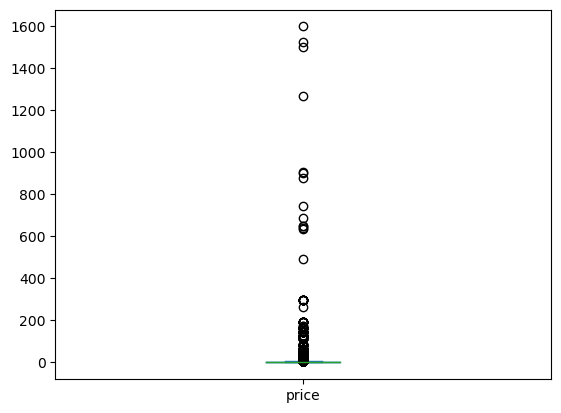

In [12]:
ot['price'].plot.box()

### It is clear that there are outliers on the price column. Let's check how many transactions are with price equal to zero

In [13]:
# Number of transactions with price equal to zero
n_price_zero = ot[ot['price'] == 0].shape[0]
print(f"There are {n_price_zero} transactions with price zero. That represents {round(n_price_zero * 100 / ot.shape[0], 2)} % of the data, therefore they are gonna be removed from the dataset.")

There are 34 transactions with price zero. That represents 0.01 % of the data, therefore they are gonna be removed from the dataset.


In [14]:
ot.drop(ot[ot['price'] == 0].index, axis=0, inplace=True)
ot.reset_index(inplace=True, drop=True)

In [15]:
# Let's start by exploring the outliers in the price column
_, mean_price, std_price, min_price, Q1_price, Q2_price, Q3_price, max_price = ot.price.describe()
IQR_price = Q3_price - Q1_price
low_lim_price = Q1_price - 1.5 * IQR_price
up_lim_price = Q3_price + 1.5 * IQR_price

Text(0.5, 23.52222222222222, 'Price (pounds)')

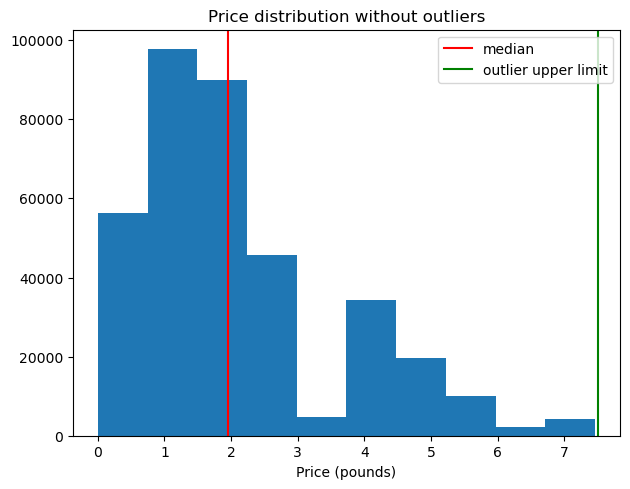

In [16]:
# Price histogram plotting
plt.hist(ot.price[ot['price'] < up_lim_price])
plt.axvline(x=Q2_price, color='red', label='median')
plt.axvline(x=up_lim_price, color='green', label='outlier upper limit')
plt.title("Price distribution without outliers")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Price (pounds)')

In [17]:
outlier_perc = round(ot[ot['price'] >= up_lim_price].shape[0] * 100 / ot.shape[0], 2)
print(f"{outlier_perc} % of my data are outliers on the price variable")

8.75 % of my data are outliers on the price variable


## To appling the k-means to segment my data I must handle the outliers because they affect the centroids' calculation from the method

### Let's explore seasonality in the data

In [18]:
# Setting up monthly, yearly, daily data
ot['invoice_year'] = ot['invoice_date'].dt.year
ot['invoice_month'] = ot['invoice_date'].dt.month
ot['invoice_weekday'] = ot['invoice_date'].dt.dayofweek
ot['invoice_dayname'] = ot['invoice_date'].dt.day_name()

In [19]:
# Defining color palette for plots
palette = sns.color_palette("tab10")

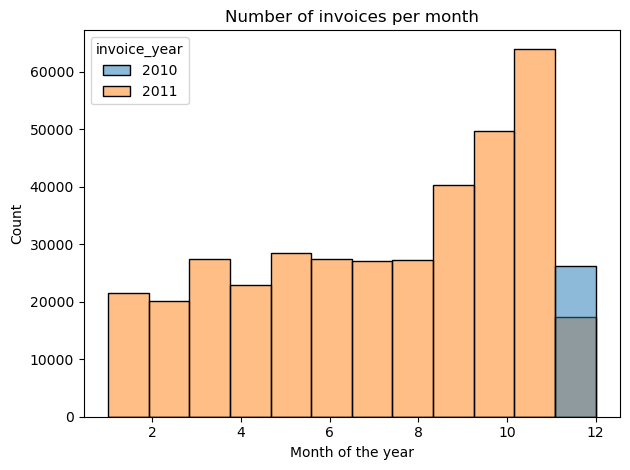

In [20]:
# Distribution of invoices per month
sns.histplot(data=ot, x='invoice_month', hue='invoice_year', bins=12, kde=False, palette=palette)
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")
plt.tight_layout()
plt.savefig("../visualizations/invoice_month.png")

### The number of invoice has a boost from September on, having a peak on November (presumably because of Black Friday) reachig its lowest point on December 2011.

In [21]:
# To plot the days in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ot['invoice_dayname'] = pd.Categorical(ot['invoice_date'].dt.day_name(), categories=day_order, ordered=True)

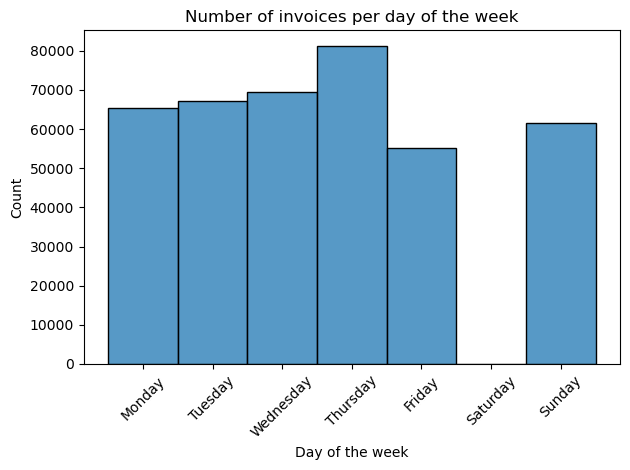

In [22]:
# Distributions of invoices per day of the week
sns.histplot(data=ot, x='invoice_dayname', multiple='stack', bins=12, kde=False)
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visualizations/invoice_weekday.png")

In [23]:
ot['invoice_dayname'].unique()

['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']

### The number of invoice has a peak on Thursdays. It is interesting that there is no data available for Saturdays

## Let's explore some KPIs

In [24]:
# Line Items (Number of products per invoice)
line_items = ot.groupby("invoice")['stock_code'].count()
print(f"On average, there are {round(line_items.mean())} stock codes per invoice")

On average, there are 18 stock codes per invoice


In [25]:
# Average order value per invoice
avg_order = ot.groupby("invoice").sum()['total_order_value']
print(f"The average purchase per invoice is {round(avg_order.mean(), 2)} pounds")

The average purchase per invoice is 380.18 pounds


In [26]:
# Average order value per customer
cust_spent = ot.groupby("customer_id").sum()['total_order_value']
print(f"In average the customer spent {round(cust_spent.mean(),2)} pounds from December 2010 to December 2011")

In average the customer spent 1899.01 pounds from December 2010 to December 2011


In [27]:
# Number of customers who spent more than the average
cust_above_avg = (cust_spent > cust_spent.mean()).sum() 
print(f"There are {cust_above_avg} customers (out of {ot['customer_id'].nunique()}) who spent more than the average customers")

There are 901 customers (out of 4362) who spent more than the average customers


In [28]:
# Average invoices per customer
inv_cust = ot.groupby('customer_id').count()['invoice']
print(f"The customers made on average {round(inv_cust.mean())} purchases")

The customers made on average 92 purchases


In [29]:
# How many customers are above the average invoice per customer?
print(f"There are {(inv_cust > inv_cust.mean()).sum()} customers who made more purchases than the average")

There are 1192 customers who made more purchases than the average


In [30]:
# filtering the data by month and year
idx_month_year = (ot['invoice_month'] == 11) & (ot['invoice_year'] == 2011) 
ot[idx_month_year].groupby("customer_id").agg({'invoice': 'count', 'stock_code': 'nunique'}).sort_values(by='invoice', ascending=False)

,invoice,stock_code
customer_id,,
u14096,1894,836
u12748,1598,885
u17841,1369,579
u14911,937,568
u16549,502,303
...,...,...
u14235,1,1
u1808,1,1
u14292,1,1


### For the top 5 customers/products check the purchases on time.

### Let's explore the data grouped by customer

In [31]:
cust_data = pd.DataFrame()
cust_group = ot.groupby('customer_id')

In [32]:
# Let's define customer loyalty as the difference in time between the 1st and the last purchase
delta_date = (ot.groupby('customer_id').first()['invoice_date'] - ot.groupby('customer_id').last()['invoice_date']).abs()
cust_data['loyalty_time'] = delta_date.dt.days

In [33]:
once_cust = cust_data[cust_data['loyalty_time'] == 0].shape[0]
print(f"There are {once_cust} customer with less than 1 day of loyalty. This represent {round(once_cust *100 / cust_data.shape[0])}% of the total clients")

There are 1615 customer with less than 1 day of loyalty. This represent 37% of the total clients


In [34]:
print(f"The average loyalty time of the clients is {round(cust_data['loyalty_time'].mean())} days")
round(cust_data['loyalty_time'].min()), round(cust_data['loyalty_time'].max())

The average loyalty time of the clients is 128 days


(0, 373)

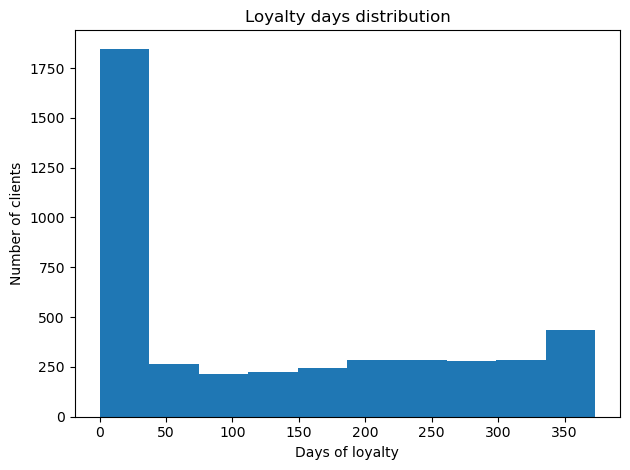

In [35]:
plt.hist(cust_data['loyalty_time'])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution_cust_onlyonce.png")

### Excluding the once in a life time clients the distribution of loyalty days is shown below

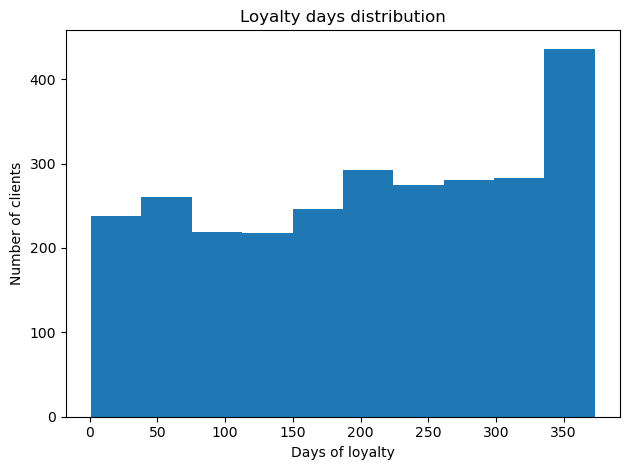

In [36]:
plt.hist(cust_data['loyalty_time'][cust_data.sort_values(by='loyalty_time', ascending=False)['loyalty_time']>0])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution.png")

In [171]:
return_dict = {'total_order_value': 'sum', 'invoice_year': 'unique'}
custid_return = cust_group.sum()[cust_group['quantity'].sum()<=0]
cust_group.sum()[cust_group['quantity'].sum()<=0].shape[0] + cust_group.sum()[cust_group['quantity'].sum()>0].shape[0]

4362

In [113]:
re_list = cust_group.sum()[cust_group.sum()['quantity']<=0].index.tolist()

In [151]:
return_cust_group = ot[ot['quantity'] <= 0].groupby('customer_id').sum()
return_cust_group[~return_cust_group.index.isin(re_list)]
(return_cust_group['quantity'] <=0).sum()

1534

### There 42 customers with quantity less than or equal to  0. That can be either because the returns were processed on the data's time-window but the transactions were done before, or because the transaction and the return were processed on the data's time-window. In the next cell, the table showcase every invoice for every customer with at least one return

In [38]:
grouped = ot.groupby(["customer_id", "invoice"]).sum()
grouped

price  quantity  total_order_value  invoice_year  \
customer_id invoice                                                     
u12346      541431    1.04     74215           77183.60          2011   
            C541433   1.04    -74215          -77183.60          2011   
u12347      537626   89.59       319             711.79         62310   
            542237   73.17       315             475.39         58319   
            549222   62.29       483             636.25         48264   
...                    ...       ...                ...           ...   
u18283      579673   81.78       132             220.31        100550   
            580872   65.38       142             208.00        100550   
u18287      554065   56.92       488             765.28         58319   
            570715   45.70       990            1001.32         76418   
            573167    1.93       108              70.68          6033   

                     invoice_month  invoice_weekday  
customer_id invoice                                  
u12346      541431               1                1  
            C541433              1                1  
u12347      537626             372               31  
            542237              29               58  
            549222              96               72  
...                            ...              ...  
u18283      579673             550              100  
            580872             600               50  
u18287      554065             145              174  
            570715             380               76  
            573167              30               12  

[21788 rows x 6 columns]

In [39]:
grouped = ot[ot['quantity'] <= 0].groupby(["customer_id", "invoice"]).sum()
grouped

price  quantity  total_order_value  invoice_year  \
customer_id invoice                                                     
u12346      C541433   1.04    -74215          -77183.60          2011   
u12352      C547388  16.69       -63            -120.33         14077   
u12359      C549955  17.90        -4             -35.80          4022   
            C580165  69.35        -6             -91.25          8044   
u12362      C544902   4.90        -2              -4.90          4022   
...                    ...       ...                ...           ...   
u18274      C577832  40.39       -88            -175.92         22121   
u18276      C577386   6.25        -1              -6.25          2011   
            C577390   6.25        -1              -6.25          2011   
u18277      C542086  12.75        -1             -12.75          2011   
u18282      C562808   0.29        -5              -1.45          2011   

                     invoice_month  invoice_weekday  
customer_id invoice                                  
u12346      C541433              1                1  
u12352      C547388             21                7  
u12359      C549955              8                4  
            C580165             48               16  
u12362      C544902              4                6  
...                            ...              ...  
u18274      C577832            121               11  
u18276      C577386             11                4  
            C577390             11                4  
u18277      C542086              1                1  
u18282      C562808              8                1  

[3383 rows x 6 columns]

# Why there are just 42 customers out of 1534 (from data exploration notebook) that returned at least once? 

In [84]:
return_dict = {'quantity': 'sum', 'total_order_value': 'sum', 'invoice_year': 'unique', 'invoice_month': 'unique'}
ot[ot['customer_id'].isin(custid_return.index)].groupby(['customer_id']).agg(return_dict)

,quantity,total_order_value,invoice_year,invoice_month
customer_id,,,,
u12346,0,0.000000e+00,[2011],[1]
u12454,0,0.000000e+00,[2011],[10]
u12558,0,6.217249e-15,[2011],[12]
u12605,-4,-7.500000e+00,[2010],[12]
u12607,0,-3.552714e-15,[2011],[10]
u12666,-56,-2.274400e+02,[2010],[12]
u1287,-2,-1.490000e+01,[2010],[12]
u12943,-1,-3.750000e+00,[2011],[2]
u13364,0,-1.776357e-15,[2011],"[9, 10]"


In [85]:
# Getting list of invoice and customers whose transactions and returns were processed on the time window of the data
list = ot[ot['customer_id'].isin(custid_return.index)].groupby(['customer_id', 'invoice']).agg(return_dict)#.index.values.tolist()
list

quantity  total_order_value invoice_year invoice_month
customer_id invoice                                                        
u12346      541431      74215           77183.60       [2011]           [1]
            C541433    -74215          -77183.60       [2011]           [1]
u12454      571255       1006            3528.34       [2011]          [10]
            C571499     -1006           -3528.34       [2011]          [10]
u12558      580158        196             269.96       [2011]          [12]
...                       ...                ...          ...           ...
u18256      C539486       -70             -50.10       [2010]          [12]
u18268      561680          2              25.50       [2011]           [7]
            C561590        -2             -25.50       [2011]           [7]
u18274      575485         88             175.92       [2011]          [11]
            C577832       -88            -175.92       [2011]          [11]

[64 rows x 4 columns]

### I will perform a customer segmentation considering just the transactions without any return. Therefore, I will create two new datasets. The first one excluding the returned transactions and the second one with just the returned transactions.

In [88]:
ot[ot['customer_id'].isin(custid_return.index)]

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_year,invoice_month,invoice_weekday,invoice_dayname
271,C536850,22942,CHRISTMAS LIGHTS 10 SANTAS,7.65,-48,-367.20,2010-12-03 09:47:00,u14213,United Kingdom,2010,12,4,Friday
335,C536812,22595,CHRISTMAS GINGHAM HEART,0.72,-144,-103.68,2010-12-02 16:58:00,u16546,United Kingdom,2010,12,3,Thursday
671,C538100,84798A,PINK FOXGLOVE ARTIIFCIAL FLOWER,2.55,-12,-30.60,2010-12-09 15:00:00,u16579,United Kingdom,2010,12,3,Thursday
845,C537860,22637,PIGGY BANK RETROSPOT,2.55,-6,-15.30,2010-12-08 16:15:00,u16252,United Kingdom,2010,12,2,Wednesday
1387,C538123,22956,36 FOIL HEART CAKE CASES,2.10,-2,-4.20,2010-12-09 15:41:00,u12605,Germany,2010,12,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390467,575485,84988,SET OF 72 PINK HEART PAPER DOILIES,1.45,12,17.40,2011-11-09 17:03:00,u18274,United Kingdom,2011,11,2,Wednesday
394597,580158,23158,SET OF 5 LUCKY CAT MAGNETS,2.08,36,74.88,2011-12-02 10:41:00,u12558,USA,2011,12,4,Friday
395557,580158,22712,CARD DOLLY GIRL,0.42,12,5.04,2011-12-02 10:41:00,u12558,USA,2011,12,4,Friday
398815,C581229,23158,SET OF 5 LUCKY CAT MAGNETS,2.08,-36,-74.88,2011-12-08 10:14:00,u12558,USA,2011,12,3,Thursday
